In [28]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [3]:
image_width = 224
image_height = 224

vgg_conv = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [26]:
# Freeze the layers except the last 2 layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x00000204F8720C18> False
<keras.layers.convolutional.Conv2D object at 0x00000204F8720D68> False
<keras.layers.convolutional.Conv2D object at 0x00000204F7476240> False
<keras.layers.pooling.MaxPooling2D object at 0x00000204F739B7F0> False
<keras.layers.convolutional.Conv2D object at 0x00000204F7388BE0> False
<keras.layers.convolutional.Conv2D object at 0x00000204F7388E48> False
<keras.layers.pooling.MaxPooling2D object at 0x00000204F73764A8> False
<keras.layers.convolutional.Conv2D object at 0x00000204F736D630> False
<keras.layers.convolutional.Conv2D object at 0x00000204F73623C8> False
<keras.layers.convolutional.Conv2D object at 0x00000204F73599B0> False
<keras.layers.pooling.MaxPooling2D object at 0x00000204F733F0F0> False
<keras.layers.convolutional.Conv2D object at 0x00000204E3500E80> False
<keras.layers.convolutional.Conv2D object at 0x00000204F7927BE0> False
<keras.layers.convolutional.Conv2D object at 0x00000204F5967BE0> False
<keras.

In [29]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

# model.add(layers.Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(layers.Dropout(0.5))
# 
model.add(layers.Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.0001)))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               6422784   
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 1285      
Total params: 21,139,781
Trainable params: 6,424,581
Non-trainable params: 14,715,200
________________________________________________________

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

# Change the batchsize according to your system RAM
train_batchsize = 16
val_batchsize = 10
#train_dir = "D:/retinal_data_set_original/_1000_per_class_train/augmented_224/train"
train_dir = "D:/retinal_data_set_original/original/new_train"
#validation_dir = "D:/retinal_data_set_original/_1000_per_class_train/augmented_224/validation"
validation_dir = "D:/retinal_data_set_original/original/new_valid"
test_dir = "D:/retinal_data_set_original/original/new_test"

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=train_batchsize,
        shuffle=True,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_width, image_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 8000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [31]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

In [32]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size,
      verbose=1)
 
# Save the model
model.save('D:/retinal_data_set_original/original/models/vgg16/vgg16_dr_last2.h5')

Epoch 1/30
500/500 [==============================] - 546s 1s/step - loss: 1.2336 - acc: 0.5104 - val_loss: 0.9352 - val_acc: 0.6060
Epoch 2/30
500/500 [==============================] - 549s 1s/step - loss: 0.8776 - acc: 0.6400 - val_loss: 0.7736 - val_acc: 0.6910
Epoch 3/30
500/500 [==============================] - 549s 1s/step - loss: 0.7379 - acc: 0.7051 - val_loss: 0.7379 - val_acc: 0.6880
Epoch 4/30
500/500 [==============================] - 549s 1s/step - loss: 0.6514 - acc: 0.7455 - val_loss: 0.8196 - val_acc: 0.6810
Epoch 5/30
500/500 [==============================] - 549s 1s/step - loss: 0.5838 - acc: 0.7740 - val_loss: 0.5768 - val_acc: 0.7710
Epoch 6/30
500/500 [==============================] - 548s 1s/step - loss: 0.5073 - acc: 0.8079 - val_loss: 0.8869 - val_acc: 0.6750
Epoch 7/30
500/500 [==============================] - 549s 1s/step - loss: 0.4674 - acc: 0.8237 - val_loss: 0.6380 - val_acc: 0.7450
Epoch 8/30
500/500 [==============================] - 548s 1s/step - 

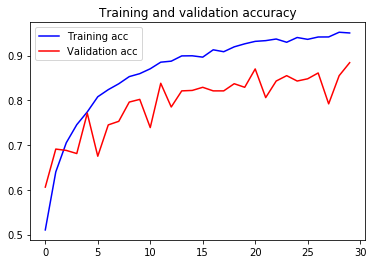

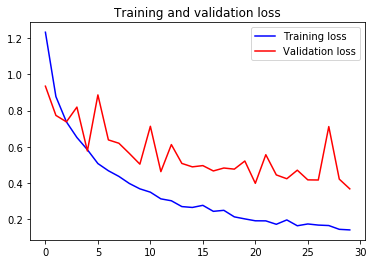

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [5]:
# Returns a compiled model identical to the previous one
loaded_model = load_model('D:/retinal_data_set_original/original/models/vgg16/vgg16_dr_last2.h5')

In [5]:
#Confution Matrix and Classification Report
Y_pred = loaded_model.predict_generator(validation_generator, validation_generator.samples // validation_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[179  12   3   6   0]
 [ 19 171   8   2   0]
 [  8  10 163  12   7]
 [  8   8  11 172   1]
 [  0   0   1   0 199]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.84      0.90      0.86       200
    mild-npdr       0.85      0.85      0.85       200
moderate-npdr       0.88      0.81      0.84       200
  severe-npdr       0.90      0.86      0.88       200
          pdr       0.96      0.99      0.98       200

  avg / total       0.88      0.88      0.88      1000



In [6]:
#Confution Matrix and Classification Report for testset
Y_pred_for_test = loaded_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
Y_pred_for_test = np.argmax(Y_pred_for_test, axis=1)
print('Confusion Matrix for testset')
print(confusion_matrix(test_generator.classes, Y_pred_for_test))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(test_generator.classes, Y_pred_for_test, target_names=target_names))

Confusion Matrix for testset
[[169  22   8   1   0]
 [ 25 167   3   5   0]
 [ 13  13 153  20   1]
 [  5   9  10 173   3]
 [  0   0   0   1 199]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.80      0.84      0.82       200
    mild-npdr       0.79      0.83      0.81       200
moderate-npdr       0.88      0.77      0.82       200
  severe-npdr       0.86      0.86      0.86       200
          pdr       0.98      0.99      0.99       200

  avg / total       0.86      0.86      0.86      1000



In [33]:
# generate roc curve
n_classes = 5

# Plot linewidth.
lw = 2

#convert original class labels to the one-hot-encoding
y_test = np_utils.to_categorical(test_generator.classes, 5)

Y_test_pred = loaded_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
Y_test_predicted = np.argmax(Y_test_pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [36]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

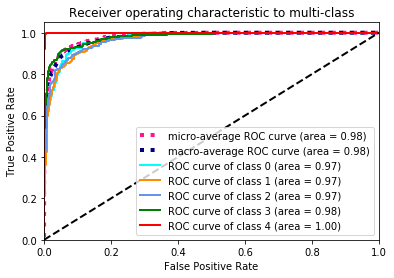

In [38]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

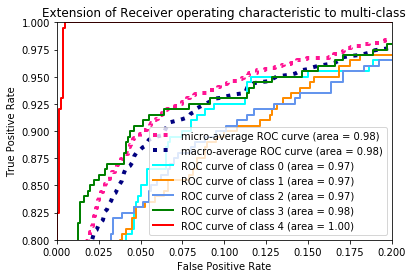

In [39]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()